In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from landlab.components import SinkFillerBarnes, FlowAccumulator, DepressionFinderAndRouter, FlowDirectorMFD
from landlab.io import esri_ascii
from landlab.plot.imshow import imshow_grid
from landlab.plot.imshow import imshow_grid_at_node, imshow_grid_at_cell
from matplotlib.colors import ListedColormap

from landlab.components.landslides import LandslideProbability
#from landlab.components.mass_wasting_router.landslide_mapper import LandslideMapper as LM
from landlab.components.mass_wasting_runout import MassWastingRunout
from landlab.grid.mappers import map_node_to_cell
from potential_evapotranspiration_field_OFFICIAL import PotentialEvapotranspiration  
from radiation_field_OFFICIAL import Radiation 
from soil_moisture_dynamics import SoilMoisture

**Import the DEM of the study watershed, find outlet**

In [3]:
# with open("Stehekin_10m.asc") as f:
#     grid = esri_ascii.load(f, name="topographic__elevation")

# Z = grid.at_node["topographic__elevation"]

# grid.set_nodata_nodes_to_closed(Z, -999999)

# # find the lowest point on our DEM?
# outlet_id = grid.core_nodes[np.argmin(grid.at_node['topographic__elevation'][grid.core_nodes])]

# # set the lowest point as the outlet, make all the nodes above this point core nodes
# grid.set_watershed_boundary_condition_outlet_id(outlet_id, Z)

# Zmin=np.min(grid.at_node['topographic__elevation'][grid.core_nodes])  #let's find the lowest point to scale our lapse rate
# Zmax=np.max(grid.at_node['topographic__elevation'][grid.core_nodes])  # maximum elevation

# print("Outlet ID=", outlet_id)                                        # print outlet id number
# print("Outlet elevation=",grid.at_node['topographic__elevation'][outlet_id])        # print elevation of outlet node
# print("Min elevation of core nodes=", Zmin) # print minimum elevation of core nodes
# print("Max elevation of core nodes=", Zmax) # print maximum elevation of core nodes






from pathlib import Path
from landlab.io import esri_ascii
import numpy as np

os.chdir("/home/abdullah/fire-debrisflow-ml/data")

asc_dir = Path("/home/abdullah/fire-debrisflow-ml/data")
dem_path = asc_dir / "topographic__elevation.asc" 

with dem_path.open() as f:
    grid = esri_ascii.load(f, name="topographic__elevation")

Z = grid.at_node["topographic__elevation"]
grid.set_nodata_nodes_to_closed(Z, -99999)

outlet_id = grid.core_nodes[np.argmin(grid.at_node["topographic__elevation"][grid.core_nodes])]
grid.set_watershed_boundary_condition_outlet_id(outlet_id, Z)

Zmin = np.min(grid.at_node["topographic__elevation"][grid.core_nodes])
Zmax = np.max(grid.at_node["topographic__elevation"][grid.core_nodes])

print("Outlet ID=", outlet_id)
print("Outlet elevation=", grid.at_node["topographic__elevation"][outlet_id])
print("Min elevation of core nodes=", Zmin)
print("Max elevation of core nodes=", Zmax)


Outlet ID= 791
Outlet elevation= -999999.0
Min elevation of core nodes= -999999.0
Max elevation of core nodes= 1808.6389


In [4]:
print('Number of nodes=', grid.number_of_nodes)
print('Number of core nodes=', grid.number_of_core_nodes)

cell_width=grid.dx
cell_width

print('Area_of_core_nodes km2=', grid.number_of_core_nodes*grid.dx*grid.dy/1000000)

Number of nodes= 513500
Number of core nodes= 510623
Area_of_core_nodes km2= 51.0623


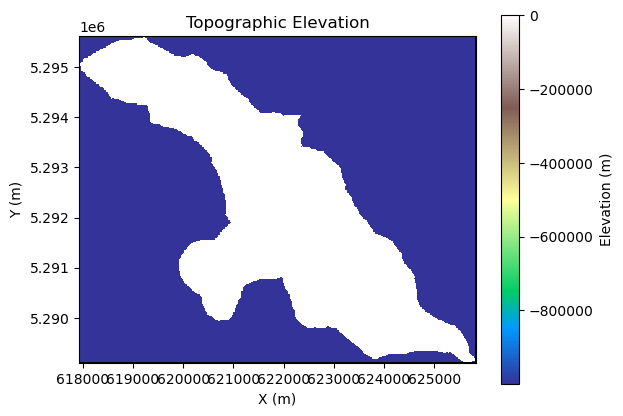

In [36]:
imshow_grid(grid,'topographic__elevation', plot_name = 'Topographic Elevation',
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'),
            cmap = 'terrain')
plt.show()

**Fill sinks and accumulate flow, calculate slope, aspect, hillshade**

In [5]:
# fill sinks to see if Flow Accumulator works better, this needs an outlet ID. if depression finder and router is used this step can be skipped, as long as the outlet drainge area is consisten with the area calculated above
sfb = SinkFillerBarnes(grid,'topographic__elevation', method='D8', fill_flat = False,
                      ignore_overfill = False)
sfb.run_one_step()

fa = FlowAccumulator(grid,
                     surface='topographic__elevation',
                     flow_director='FlowDirectorD8',
                     runoff_rate=None,
                     #depression_finder='DepressionFinderAndRouter'
                    )

(da, q) = fa.accumulate_flow()

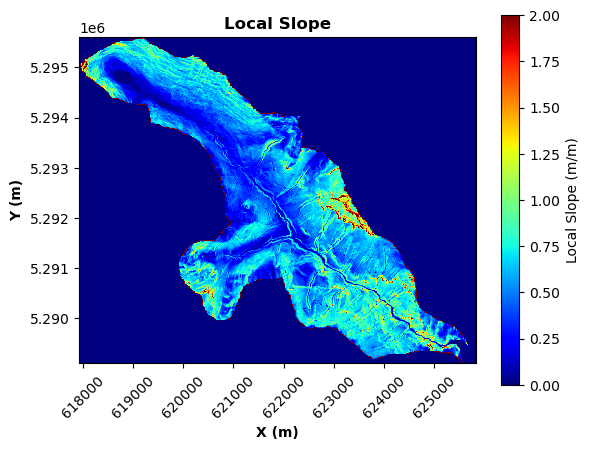

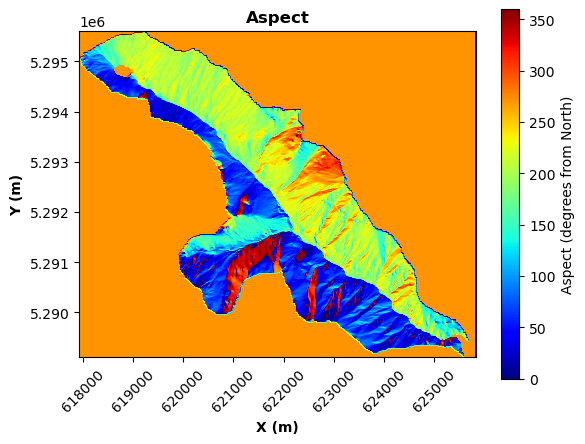

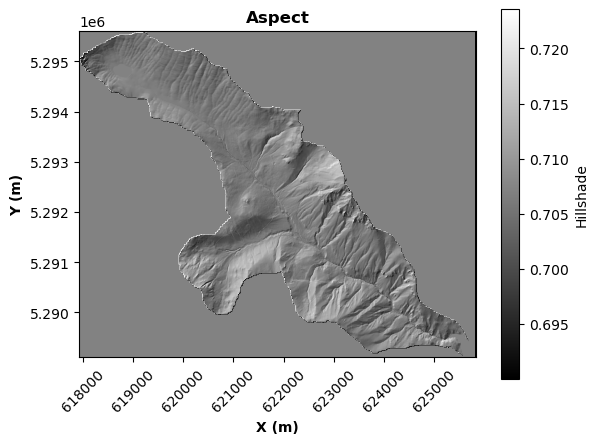

In [6]:
#Plotting slope, aspect, and hillshade
grid.add_field('topographic__slope', grid.at_node['topographic__steepest_slope'], at='node', clobber=True) ## used by the landslide model

imshow_grid(grid,'topographic__steepest_slope', plot_name = 'Local Slope',
            var_name = 'Local Slope', var_units = 'm/m', grid_units = ('m','m'),
            cmap = 'jet', limits=(0,2))
plt.title('Local Slope', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()


aspect=grid.calc_aspect_at_node(elevs=Z)
slope=grid.calc_slope_at_node(elevs=Z)
hillshade=grid.calc_hillshade_at_node(elevs=Z, alt=45, az=315, slp=slope, asp=aspect)

_=grid.add_field('Aspect', aspect, at='node', clobber=True)
_=grid.add_field('Hillshade', hillshade, at='node', clobber=True)

#Aspect
imshow_grid(grid,'Aspect', plot_name = 'Aspect',
            var_name = 'Aspect', var_units = 'degrees from North', grid_units = ('m','m'),
            cmap = 'jet', limits=(0,360))
plt.title('Aspect', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

#Hillshade
imshow_grid(grid,'Hillshade', plot_name = 'Aspect',
            var_name = 'Hillshade', grid_units = ('m','m'),
            cmap = 'gray')
plt.title('Aspect', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [7]:
cell_width=grid.dx

ca=grid.at_node['drainage_area']/cell_width  # now calculate SCA

_=grid.add_field('topographic__specific_contributing_area', ca, at='node', clobber=True)

**Soil Properties:** thickness, density, internal friction angle, saturated hydraulic conductivity, water holding parameters**

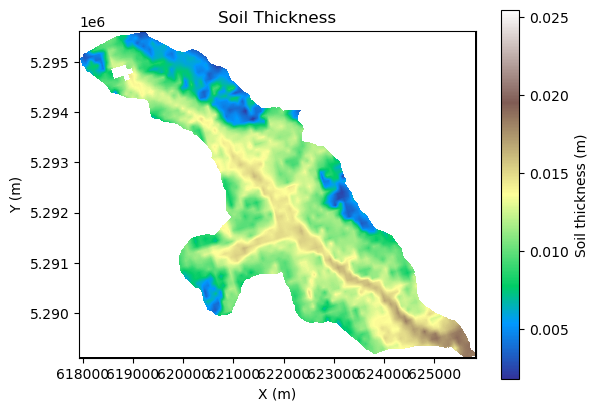

In [8]:
# Soil Thickness data from SOLIS

with open("soil__thickness.asc") as f:
    hs_grid = esri_ascii.load(f, name="soil__thickness")

hs = hs_grid.at_node["soil__thickness"]

_=grid.add_field('soil__thickness', hs/100, at='node', clobber=True)   #SOLS data in cmm

grid.set_nodata_nodes_to_closed(hs, 2.549999999999999822e+00)

imshow_grid(grid,'soil__thickness', plot_name = 'Soil Thickness',
            var_name = 'Soil thickness', var_units = 'm', grid_units = ('m','m'),
            cmap = 'terrain')

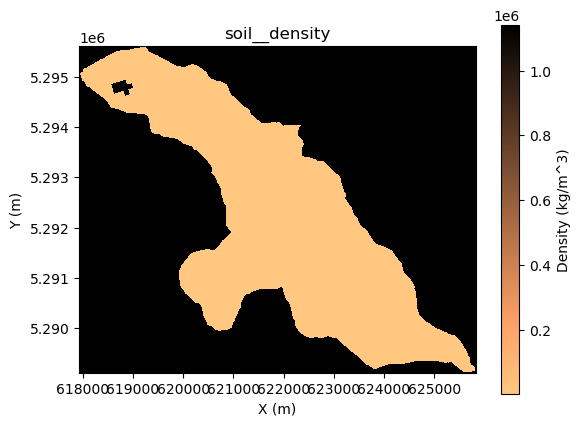

In [9]:
#Soil density data from XXX

with open("soil__density.asc") as f:
    ro_grid = esri_ascii.load(f, name="soil__density")

ro = ro_grid.at_node["soil__density"]

_=grid.add_field('soil__density', ro, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(ro, 4.259999999999999898e-01)

imshow_grid_at_node(grid,'soil__density', plot_name = 'Soil Density',
            var_name = 'Density', var_units = 'kg/m^3', grid_units = ('m','m'),
            cmap = 'copper_r')

In [10]:
#Soil Internal friction angle from soil texture classification and look-up values from XX

with open("soil__internal_friction_angle.asc") as f:
    phi_grid = esri_ascii.load(f, name="soil__internal_friction_angle")

phi = phi_grid.at_node["soil__internal_friction_angle"]

_=grid.add_field('soil__internal_friction_angle', phi, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(phi, 2.700000000000000000e+01)

#imshow_grid_at_node(grid,'soil__internal_friction_angle', plot_name = 'Friction angle',
#            var_name = 'Phi', var_units = 'degrees', grid_units = ('m','m'),
#            cmap = 'viridis')

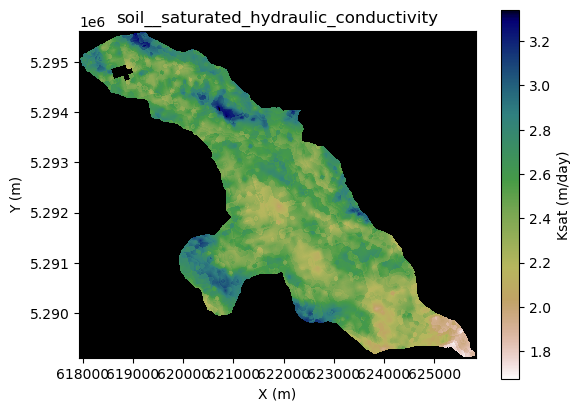

In [12]:
## Porosity

with open("porosity.asc") as f:
    n_grid = esri_ascii.load(f, name="porosity")

n = n_grid.at_node["porosity"]

_=grid.add_field('porosity', n, at='node', clobber=True)

## Field Capacity

with open("field__capacity.asc") as f:
    fc_grid = esri_ascii.load(f, name="field__capacity")

fc = fc_grid.at_node["field__capacity"]

_=grid.add_field('field__capacity', fc, at='node', clobber=True)


## Wilting Point

with open("wilting__point.asc") as f:
    wp_grid = esri_ascii.load(f, name="wilting__point")

wp = wp_grid.at_node["wilting__point"]

_=grid.add_field('wilting__point', wp, at='node', clobber=True)



## Saturated Hydraulic Conductivity

with open("soil__saturated_hydraulic_conductivity.asc") as f:
    ksat_grid = esri_ascii.load(f, name="soil__saturated_hydraulic_conductivity")

ksat = ksat_grid.at_node["soil__saturated_hydraulic_conductivity"]

_=grid.add_field('soil__saturated_hydraulic_conductivity', ksat, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(ksat, 7.052563416309979523e+93)

imshow_grid_at_node(grid,'soil__saturated_hydraulic_conductivity', plot_name = 'Ksat',
            var_name = 'Ksat', var_units = 'm/day', grid_units = ('m','m'),
            cmap = 'gist_earth_r')

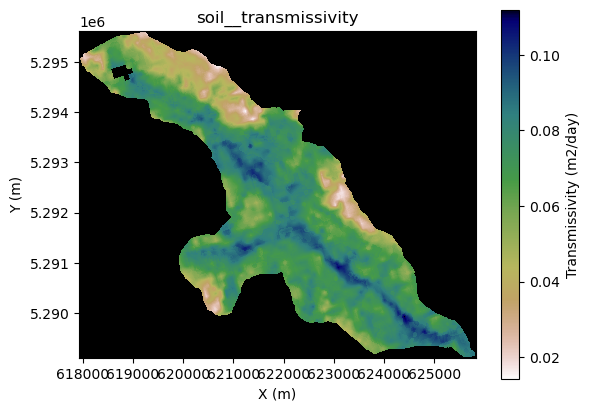

In [13]:
To=ksat*2.5*(hs/100) #m^2/day
for i in range(len(To)):
    if To[i] <= 0:
        To[i] = 0.01

_=grid.add_field('soil__transmissivity', To, at='node',clobber=True)

imshow_grid_at_node(grid,'soil__transmissivity', plot_name = 'Transmissivity',
            var_name = 'Transmissivity', var_units = 'm2/day', grid_units = ('m','m'),
            cmap = 'gist_earth_r')

**Import Vegetation Functional Type Data used in the Ecohydrology Model:** Land cover data from National Landuse and Landcover data, note this data was reduced to tree, grass, shrub PFTs and bare soil for the ecohydrology model

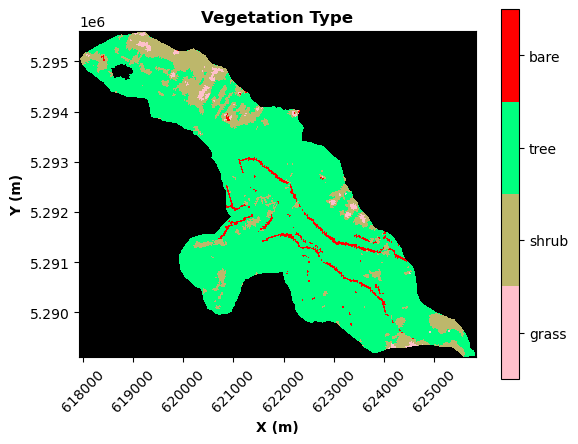

In [14]:
with open("vegetation__plant_functional_type.asc") as f:
    vt_grid = esri_ascii.load(f, name="vegetation__plant_functional_type")

vt = vt_grid.at_node["vegetation__plant_functional_type"]

_=grid.add_field('vegetation__plant_functional_type', vt, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(vt, -9.999000000000000000e+03)

grid.add_field('vegetation__plant_functional_type', vt.astype(int), at='node', clobber=True)
imshow_grid_at_node(grid, 'vegetation__plant_functional_type', plot_name = 'Vegetation Type',
            cmap = ListedColormap(['pink',"darkkhaki", "springgreen", "red"], N=4), limits = (-0.5,3.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3])
cb.set_ticklabels(['grass', 'shrub','tree','bare'])
plt.title('Vegetation Type', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Map PFT from node to cell as the ecohydrology model operates on cells
grid['cell']['vegetation__plant_functional_type']=map_node_to_cell(grid, "vegetation__plant_functional_type").astype(int)
for i in range(len(grid['cell']['vegetation__plant_functional_type'])):
        if grid['cell']['vegetation__plant_functional_type'][i] < 0:
            grid['cell']['vegetation__plant_functional_type'][i] = 0

**Adding Leaf Area Index for different PFTs:** this can be used from field observations

In [16]:
LAI_grass = 1.5
LAI_shrub = 2.0
LAI_tree  = 4.0

## create or replace the field
grid.add_field('vegetation__live_leaf_area_index',
               np.zeros(grid.number_of_nodes, dtype=float),
               at='node', clobber=True)

pft = grid.at_node['vegetation__plant_functional_type']
lai = grid.at_node['vegetation__live_leaf_area_index']  # we can pass this directly

for i in range(grid.number_of_nodes):
    if pft[i] == 0:
        lai[i] = LAI_grass
    elif pft[i] == 1:
        lai[i] = LAI_shrub
    elif pft[i] == 2:
        lai[i] = LAI_tree
    elif pft[i] == 3:
        lai[i] = 1   ## default for bare

grid['cell']['vegetation__live_leaf_area_index']=map_node_to_cell(grid, "vegetation__live_leaf_area_index")

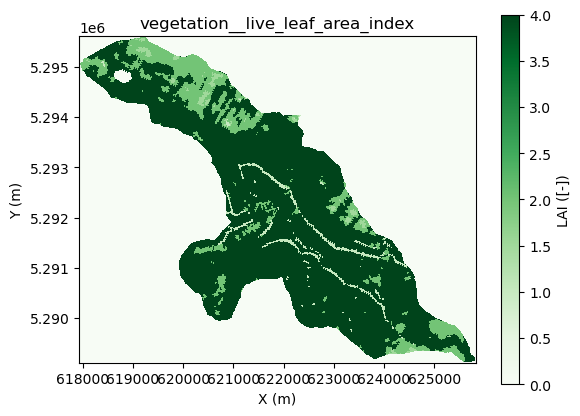

In [17]:
imshow_grid_at_cell(grid,'vegetation__live_leaf_area_index', plot_name = 'LAI',
            var_name = 'LAI', var_units = '[-]', grid_units = ('m','m'),
            cmap = 'Greens')

**Root Cohesion Values:** Min, Mode, Max Root Cohesion derived from look-up tables (Strauch et al., 2018)

In [18]:
with open("soil__maximum_total_cohesion.asc") as f:
    cmax_grid = esri_ascii.load(f, name="soil__maximum_total_cohesion")

cmax = cmax_grid.at_node["soil__maximum_total_cohesion"]

_=grid.add_field('soil__maximum_total_cohesion', cmax, at='node', clobber=True)


with open("soil__mode_total_cohesion.asc") as f:
    cmode_grid = esri_ascii.load(f, name="soil__mode_total_cohesion")

cmode = cmode_grid.at_node["soil__mode_total_cohesion"]

_=grid.add_field('soil__mode_total_cohesion', cmode, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(cmode, -9.999000000000000000e+03)


with open("soil__minimum_total_cohesion.asc") as f:
    cmin_grid = esri_ascii.load(f, name="soil__minimum_total_cohesion")

cmin = cmin_grid.at_node["soil__minimum_total_cohesion"]

_=grid.add_field('soil__minimum_total_cohesion', cmin, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(cmax, -9.999000000000000000e+03)

#imshow_grid_at_node(grid,'soil__minimum_total_cohesion_pre', plot_name = 'Minimum cohesion',
#            var_name = 'Soil Cohesion', var_units = 'Pa', grid_units = ('m','m'),
#            cmap = 'Greens')

#imshow_grid_at_node(grid,'soil__maximum_total_cohesion_pre', plot_name = 'Maximum cohesion',
#            var_name = 'Soil Cohesion', var_units = 'Pa', grid_units = ('m','m'),
#            cmap = 'Greens')

#imshow_grid_at_node(grid,'soil__mode_total_cohesion_pre', plot_name = 'Mode cohesion',
#            var_name = 'Soil Cohesion', var_units = 'Pa', grid_units = ('m','m'), cmap = 'Greens')

#grid.add_field('soil__mode_total_cohesion', C_mode, at='node',clobber=True)  to BE DELETED
#grid.add_field('soil__minimum_total_cohesion', C_min, at='node',clobber=True)
#grid.add_field('soil__maximum_total_cohesion', C_max, at='node', clobber=True)

**"ToBE_CHECKED" Burn severity data from MTBS**

In [19]:
with open("burn__severity.asc") as f:
    bs_grid = esri_ascii.load(f, name="burn__severity")

bs = bs_grid.at_node["burn__severity"]

_=grid.add_field('burn__severity', bs, at='node', clobber=True)

In [20]:
bs[~np.isin(bs, [2, 3, 4])] = 1

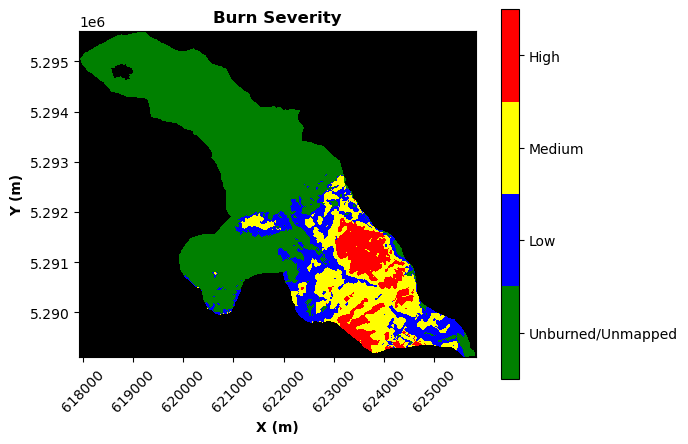

In [21]:
imshow_grid_at_node(grid, 'burn__severity', plot_name = 'Burn Severity',
            cmap = ListedColormap(['green',"blue", "yellow", "red"], N=4), limits = (0.5,4.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([1,2,3,4])
cb.set_ticklabels(['Unburned/Unmapped', 'Low','Medium','High'])
plt.title('Burn Severity', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()
plt.show()

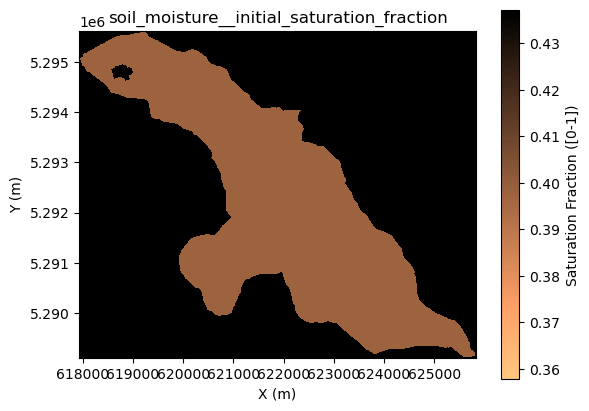

In [22]:
Saturation_fraction=(0.5*(grid.at_node['field__capacity']-grid.at_node['wilting__point'])+grid.at_node['wilting__point'])/grid.at_node['porosity']

_=grid.add_field('soil_moisture__initial_saturation_fraction', Saturation_fraction, at='node', clobber=True)

grid['cell']['soil_moisture__initial_saturation_fraction']=map_node_to_cell(grid, "soil_moisture__initial_saturation_fraction")

imshow_grid_at_node(grid,'soil_moisture__initial_saturation_fraction', plot_name = 'Saturation fraction',
            var_name = 'Saturation Fraction', var_units = '[0-1]', grid_units = ('m','m'),
            cmap = 'copper_r')

In [23]:
Latitude=47.7
Albedo=0.2

In [24]:
Zveg=0.5 # vegetation height [m]
Z_wind=2.0 # height at which wind speed was recorded. This should be above the canopy height
Vwind=3.04 # wind speed m/s
Relative_humidity=0.8 # relative humidity

https://www.wunderground.com/dashboard/pws/KWASKYKO6/table/2025-03-16/2025-03-16/monthly

In [25]:
alpha = 4.5      # °C/km lapse rate
Zref = Zmin     # m, station elevation

# Observed values (lists)
Tmin_o = [
 -0.61, 4.89, 4.78, 2.28, -0.72, -2.22, -1.50, 2.22, 0.22, 0.22,
  0.00, 2.89, 0.22, -0.72, 0.22, 0.44, 0.89, 0.28, 1.11, 1.28,
  1.28, 1.50, 0.28, 4.61, 4.72, 3.89, 6.72, 5.50, 2.72, -0.28, 4.61
] #C

Tmax_o = [
 17.72, 10.50, 8.50, 9.11, 10.61, 8.39, 12.61, 12.61, 14.50, 6.72,
 9.28, 9.22, 6.50, 6.72, 5.00, 5.50, 6.28, 8.22, 9.89, 6.22,
 5.72, 9.00, 4.80, 8.89, 19.50, 22.50, 14.61, 9.39, 13.39, 14.61, 9.61
] #C

P_obs  = [0.0, 0.0, 2.03, 7.62, 2.8, 0.0, 0.0, 0.0, 15.5, 11.43, 1.8, 14.2,
          21.1, 2.3, 28.5, 10.7, 14.5, 2.03, 1.01, 26.67, 47.24, 10.4, 120,
          42.2, 0.0, 12.2, 20.6, 14.7, 2.03, 0, 4.8] # mm

rainfall_arrays = []
tempmin_arrays = []
tempmax_arrays = []

for tmin_ref, tmax_ref, P_ref in zip(Tmin_o, Tmax_o, P_obs):

    Tmax = tmax_ref - alpha * ((Z - Zref) / 1000.0)
    Tmin = tmin_ref - alpha * ((Z - Zref) / 1000.0)
    Ta   = ((tmin_ref + tmax_ref) / 2.0) - alpha * ((Z - Zref) / 1000.0)

    P_grid = np.full_like(Z, P_ref, dtype=float)

    # store each day's fields
    rainfall_arrays.append(P_grid)
    tempmin_arrays.append(Tmin)
    tempmax_arrays.append(Tmax)

In [28]:
Z = grid.at_node["topographic__elevation"]
grid.set_nodata_nodes_to_closed(Z, -999999.0)

open_mask = grid.status_at_node != grid.BC_NODE_IS_CLOSED
print("min open elevation:", Z[open_mask].min())
print("negative open nodes:", np.sum(Z[open_mask] < 0))

min open elevation: -999998.9999999745
negative open nodes: 58


In [29]:
Z = grid.at_node["topographic__elevation"]

# Robust nodata detection
bad = np.isclose(Z, -999999.0, atol=1e-2) | (Z < -1e5)
grid.status_at_node[bad] = grid.BC_NODE_IS_CLOSED

# Optional safety (closed nodes won't be used by radiation check)
Z[bad] = 0.0

open_mask = grid.status_at_node != grid.BC_NODE_IS_CLOSED
print("min open elevation:", Z[open_mask].min())
print("negative open nodes:", np.sum(Z[open_mask] < 0))


min open elevation: 362.17578
negative open nodes: 0


In [30]:
t = 2
runoff_arrays=[]
recharge_arrays=[]
soil_moisture_arrays=[]
ET_arrays=[]
mask = np.isin(grid.at_node['burn__severity'], [2, 3, 4]) & np.isin(np.arange(grid.number_of_nodes), grid.core_nodes)

current_time=0.22
Vt=grid.at_node['vegetation__live_leaf_area_index']/4
_=grid.add_field('vegetation__cover_fraction', Vt , at='node',clobber=True)
grid['cell']['vegetation__cover_fraction']=map_node_to_cell(grid, "vegetation__cover_fraction")

for idx, (rainfall, tempmin, tempmax) in enumerate(zip(rainfall_arrays, tempmin_arrays, tempmax_arrays)):
    # Take each day's data from the above data zip

    _=grid.add_field('Precipitation', rainfall, at='node',clobber=True) #m^2/day
    grid.set_nodata_nodes_to_closed(rainfall, -9999.)

    _=grid.add_field('Tmin', tempmin , at='node',clobber=True)
    grid.set_nodata_nodes_to_closed(tempmin, -9999.)

    _=grid.add_field('Tmax', tempmax , at='node',clobber=True)
    grid.set_nodata_nodes_to_closed(tempmax, -9999.)

    # THIS IS DONE TO PASS "P" TO THE COMPONENT..?
    grid['cell']['Precipitation']=map_node_to_cell(grid, "Precipitation")
    P=grid['cell']['Precipitation']
    grid['cell']['rainfall__daily_depth'] = P
   ## Soil_Saturation=grid['cell']['soil_moisture__initial_saturation_fraction'] ERKANI--DO YOU NEED THIS

    grid['cell']['saturated__hydraulic_conductivity']=map_node_to_cell(grid, "soil__saturated_hydraulic_conductivity")
    #ksat_t_cell=grid['cell']['saturated__hydraulic_conductivity']

    #grid['cell']['saturated__hydraulic_conductivity_pre']=map_node_to_cell(grid, "soil__saturated_hydraulic_conductivity_pre")
    #ksat_cell=grid['cell']['saturated__hydraulic_conductivity_pre']

    grid['cell']['live_leaf_area_index']=map_node_to_cell(grid,"vegetation__live_leaf_area_index")
    #lai_t_cell=grid['cell']['live_leaf_area_index']

    #grid['cell']['live_leaf_area_index_pre']=map_node_to_cell(grid, "vegetation__live_leaf_area_index_pre")
    #lai_cell=grid['cell']['live_leaf_area_index_pre']

    grid['cell']['Porosity']=map_node_to_cell(grid, "porosity")  # used for calculating soil saturation
    Porosity=grid['cell']['Porosity']



    # Radiation and PET modeling
    myTmin = grid.at_node["Tmin"]
    myTmax = grid.at_node["Tmax"]

    rad = Radiation(grid, method='Grid')
    PET=PotentialEvapotranspiration(grid, method='PenmanMonteith')
    SM = SoilMoisture(grid)

    rad._current_time=current_time
    rad._latitude=Latitude
    rad._A=Albedo
    rad._Tmin = myTmin
    rad._Tmax = myTmax
    rad.update()

    PET._current_time=current_time
    PET._latitude=Latitude
    PET._a=Albedo
    PET._Tmin= myTmin
    PET._Tmax= myTmax
    PET._zm = Z_wind
    PET._zveg = Zveg * np.ones(grid.number_of_cells)
    PET._vz = Vwind * np.ones(grid.number_of_cells)
    PET._relative_humidity = Relative_humidity * np.ones(grid.number_of_cells)
    PET._LAI=lai     # it should take the node values directly now
    PET.update()

    SM._current_time=current_time
    SM._Tb = 24
    SM.update()
    print("Mean surface runoff after SM.update():", np.mean(grid.at_cell["surface__runoff"][grid.core_cells]))
    # take recharge values from cells and write them to nodes
    sm_rz_leakage = np.zeros(grid.number_of_nodes)
    # Iterate over each cell in the grid
    for cell in range(grid.number_of_cells):
    # Get the value of soil moisture root zone leakage at the current cell
        value = grid.at_cell['soil_moisture__root_zone_leakage'][cell]
    # Get the node ID at the center of the current cell
        node_id = grid.node_at_cell[cell]
    # Update the soil moisture root zone leakage at the corresponding node
        sm_rz_leakage[node_id] = value

   # Soil_Saturation=grid['cell']['soil_moisture__saturation_fraction']--- ERKANI NOT SURE IF YOU NEED THESE
   # Soil_moisture=Soil_Saturation*Porosity

    leakage_to_node = np.zeros(grid.number_of_nodes)

    runoff_to_node = np.zeros(grid.number_of_nodes)

    soil_moisture_to_node = np.zeros(grid.number_of_nodes)

    ET_to_node = np.zeros(grid.number_of_nodes)

    for cell in range(grid.number_of_cells):
    # Get the value of soil moisture root zone leakage at the current cell
        value_leakage = grid.at_cell['soil_moisture__root_zone_leakage'][cell]

        value_runoff = grid.at_cell['surface__runoff'][cell]

        value_soil_moisture = grid.at_cell['soil_moisture__saturation_fraction'][cell]

        value_actual_et = grid.at_cell['surface__evapotranspiration'][cell]

        # Get the node ID at the center of the current cell
        node_id = grid.node_at_cell[cell]

        # Update the soil moisture root zone leakage at the corresponding node
        leakage_to_node[node_id] = value_leakage

        runoff_to_node[node_id] = value_runoff

        soil_moisture_to_node[node_id] = value_soil_moisture

        ET_to_node[node_id] = value_actual_et

    recharge_arrays.append(leakage_to_node)
    runoff_arrays.append(runoff_to_node)
    soil_moisture_arrays.append(soil_moisture_to_node)
    ET_arrays.append(ET_to_node)

    current_time=SM.current_time

mean_runoff = np.mean(runoff_arrays, axis=0)
mean_recharge = np.mean(recharge_arrays, axis=0)
max_runoff = np.maximum.reduce(runoff_arrays)
max_recharge = np.maximum.reduce(recharge_arrays)

/home/abdullah/fire-debrisflow-ml/notebook/potential_evapotranspiration_field_OFFICIAL.py:418: RuntimeWarning: divide by zero encountered in divide
  self._rs = self._rl / self._LAIa


Mean surface runoff after SM.update(): 0.0
Mean surface runoff after SM.update(): 0.0
Mean surface runoff after SM.update(): 0.00029320773338955316
Mean surface runoff after SM.update(): 0.031243156847372045
Mean surface runoff after SM.update(): 0.0008888204623068383
Mean surface runoff after SM.update(): 0.0
Mean surface runoff after SM.update(): 0.0
Mean surface runoff after SM.update(): 0.0
Mean surface runoff after SM.update(): 0.32441027793705113
Mean surface runoff after SM.update(): 0.10597361354810517
Mean surface runoff after SM.update(): 0.00017727645579726031
Mean surface runoff after SM.update(): 0.22369610382289631
Mean surface runoff after SM.update(): 1.0700149974227509
Mean surface runoff after SM.update(): 0.0004658559333560816
Mean surface runoff after SM.update(): 2.7396419677116204
Mean surface runoff after SM.update(): 0.08832910079330343
Mean surface runoff after SM.update(): 0.24436775025290347
Mean surface runoff after SM.update(): 0.00029320773338955316
Mean s

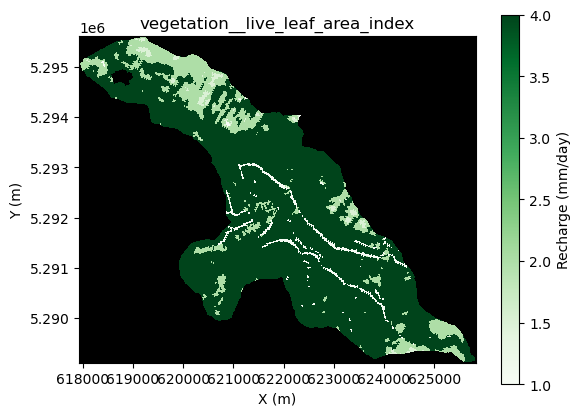

In [60]:
imshow_grid_at_node(grid,'vegetation__live_leaf_area_index', plot_name = 'Maximum Recharge',
            var_name = 'Recharge', var_units = 'mm/day', grid_units = ('m','m'),
            cmap = 'Greens')

In [31]:
imshow_grid_at_node(grid,'groundwater__runoff_mean', plot_name = 'Maximum Recharge',
            var_name = 'Recharge', var_units = 'mm/day', grid_units = ('m','m'),
            cmap = 'Greens')

FieldError: groundwater__runoff_mean

In [ ]:
imshow_grid_at_node(grid,'groundwater__recharge_mean', plot_name = 'Maximum Recharge',
            var_name = 'Recharge', var_units = 'mm/day', grid_units = ('m','m'),
            cmap = 'Greens')

In [ ]:
imshow_grid_at_node(grid,'soil__saturated_hydraulic_conductivity', plot_name = 'Maximum Recharge',
            var_name = 'Recharge', var_units = 'mm/day', grid_units = ('m','m'),
            cmap = 'Greens')

In [ ]:
_=grid.add_field('groundwater__recharge_mean', max_recharge , at='node', clobber=True)
grid['node']['groundwater__recharge_mean'][grid['node']['groundwater__recharge_mean'] <= 0] = 0.01
_=grid.add_field('groundwater__recharge_standard_deviation', max_recharge*0.1, at='node',clobber=True)
_=grid.add_field('groundwater__runoff_mean', max_runoff , at='node', clobber=True)
_=grid.add_field('test_runoff', mean_runoff , at='node', clobber=True)
_=grid.add_field('test_recharge', mean_recharge , at='node', clobber=True)

#C_mode = post_fire_cohesion(t, grid.at_node['soil__mode_total_cohesion_pre'], grid.at_node['burn__severity'])
#C_min = post_fire_cohesion(t, grid.at_node['soil__minimum_total_cohesion_pre'], grid.at_node['burn__severity'])
#C_max = post_fire_cohesion(t, grid.at_node['soil__maximum_total_cohesion_pre'], grid.at_node['burn__severity'])


number_of_iterations = 1000

LS_prob=LandslideProbability(grid,
                     number_of_iterations=number_of_iterations,
                     groundwater__recharge_distribution='lognormal_spatial', groundwater__recharge_mean=sm_rz_leakage,
                     groundwater__recharge_standard_deviation=sm_rz_leakage*0.1)

LS_prob.calculate_landslide_probability()

print('run done')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# --- Example inputs ---
core_nodes = grid.core_nodes

# Compute daily means
daily_mean_recharge = np.array([np.mean(arr[core_nodes]) for arr in recharge_arrays])
daily_mean_runoff   = np.array([np.mean(arr[core_nodes]) for arr in runoff_arrays])

# Dates for x-axis
dates = pd.date_range("2025-03-01", "2025-03-31")  # 7 days

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(dates, daily_mean_recharge, '-o', color='black', label="Recharge")
ax.plot(dates, daily_mean_runoff, '-o', color='gray', label="Runoff")

ax.set_xlabel("Date")
ax.set_ylabel("Flux (mm/day)")
ax.set_title("Daily Mean Recharge & Runoff")

# Styling
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()